In [1]:
import numpy as np
import pandas as pd

import utils
from sklearn.metrics.pairwise import paired_distances

import matplotlib.pyplot as plt
import seaborn as sns 



In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotnine as pn

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.preprocessing import StandardScaler, scale
from scipy.spatial import distance

from einops import rearrange, reduce, repeat


In [7]:
import importlib
importlib.reload(utils)


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

In [2]:
subjs = utils.ExpInfo.getSubjIDs()
task = utils.ExpInfo.taskName[0]


In [8]:
subj = subjs[0]
# iTrial = 0
wSize = 60


df_beh = utils.LoadData.behaviorData(subj, task)
_, h, _ = utils.LoadData.xhy(subj, task, wSize=wSize)
_, h_disp, _ = utils.LoadData.xhy_disp(subj, task, wSize=wSize)
dist_measure = 'euclidean'

dist_timeSeries = []
v_timeSeries = []
for iTrial in range(len(h)):
    h_trial = h[iTrial][:-1, :]
    h_disp_trial = h_disp[iTrial]

    # hidden action plan velocity
    vh = np.diff(h_trial, axis=0)
    vh_disp_dot = np.diff(h_disp_trial, axis=0)

    dist_timeSeries_ = paired_distances(h_trial, h_disp_trial, metric=dist_measure)
    v_timeSeries_ = paired_distances(vh, vh_disp_dot, metric=dist_measure)
    
    dist_timeSeries.append(dist_timeSeries_)
    v_timeSeries.append(v_timeSeries_)

    

# Position and velocity of action plan space can predict the behavior profile of an individual

In [7]:

# subj = subjs[14]
def f_group(subj):
    wSize = 60

    df_beh = utils.LoadData.behaviorData(subj, task)
    _, h, _ = utils.LoadData.xhy(subj, task, wSize=wSize)
    _, h_disp, _ = utils.LoadData.xhy_disp(subj, task, wSize=wSize)
    dist_measure = 'euclidean'


    def trial(iTrial):
        # extract data
        h_trial = h[iTrial][:-1, :]
        h_disp_trial = h_disp[iTrial]

        # hidden action plan velocity
        vh = np.diff(h_trial, axis=0)

        # dot loop
        dist_timeSeries = []
        v_timeSeries = []
        for h_disp_dot in h_disp_trial:
            # location distnace
            dist_timeSeries_ = paired_distances(
                h_trial, h_disp_dot, metric=dist_measure)
            dist_timeSeries.append(dist_timeSeries_)

            # velocity difference
            vh_disp_dot = np.diff(h_disp_dot, axis=0)
            v_timeSeries_ = paired_distances(vh, vh_disp_dot, metric=dist_measure)
            v_timeSeries.append(v_timeSeries_)

        dist_timeSeries = np.vstack(dist_timeSeries).T
        v_timeSeries = np.vstack(v_timeSeries).T

        # compute AUC for position and velocoty 
        auc_h = utils.Analysis.auc_oneVsOthers(dist_timeSeries)
        auc_v = utils.Analysis.auc_oneVsOthers(v_timeSeries)
        auc = np.vstack([auc_h, auc_v])
        auc_max = utils.findMax(auc)

        # compute emprical probability of shortist dot 
        argmin_ratio_h = utils.Analysis.argmin_ratio(dist_timeSeries)
        argmin_ratio_v = utils.Analysis.argmin_ratio(v_timeSeries)
        argmin_ratio = np.vstack([argmin_ratio_h, argmin_ratio_v])
        argmin_ratio_max = utils.findMax(argmin_ratio)
        
        
        # compute top N ratio
        topN_h = utils.Analysis.class_in_topN(dist_timeSeries)
        topN_v = utils.Analysis.class_in_topN(v_timeSeries)
        topN = np.vstack([topN_h, topN_v])
        topN_max = utils.findMax(topN)
        
        

        return {'auc_max': auc_max[0],
                'auc_prediction': auc_max[1][1]+1,
                'auc_max_type': auc_max[1][0],
                'argmin_ratio_max': argmin_ratio_max[0],
                'argmin_ratio_prediction': argmin_ratio_max[1][1]+1,
                'argmin_ratio_type': argmin_ratio_max[1][0],
                'topN_max': topN_max[0],
                'topN_prediction': topN_max[1][1]+1,
                'topN_type': topN_max[1][0]}




    d = utils.GroupOperation.map_trial(trial, range(len(h)))


    df_ = pd.concat([df_beh, pd.DataFrame(d)], axis=1)
    df_['auc_pred_accuracy'] = df_['auc_prediction'] == df_['selected dot']
    df_['auc_pred_accuracy_target'] = df_['auc_prediction'] == df_['target dot']
    df_['argmin_ratio_pred_accuracy'] = df_['argmin_ratio_prediction'] == df_['selected dot']
    df_['argmin_ratio_pred_accuracy_target'] = df_['argmin_ratio_prediction'] == df_['target dot']
    df_['topN_pred_accuracy'] = df_['topN_prediction'] == df_['selected dot']
    df_['topN_pred_accuracy_target'] = df_['topN_prediction'] == df_['target dot']
    # df_ = df_.groupby(['actual control', 'angular bias']).mean()
    # df_ = df_.reset_index()
    
    return df_

dg = utils.GroupOperation.map(f_group, subjs)
df = pd.concat(dg, axis=0)


Group loop |████████████████████████████████████████| 50/50 [100%] in 37.6s (1.33/s)                                    ████▊           | ▇▇▅ 36/50 [72%] in 25s (1.4/s, eta: 10s) 


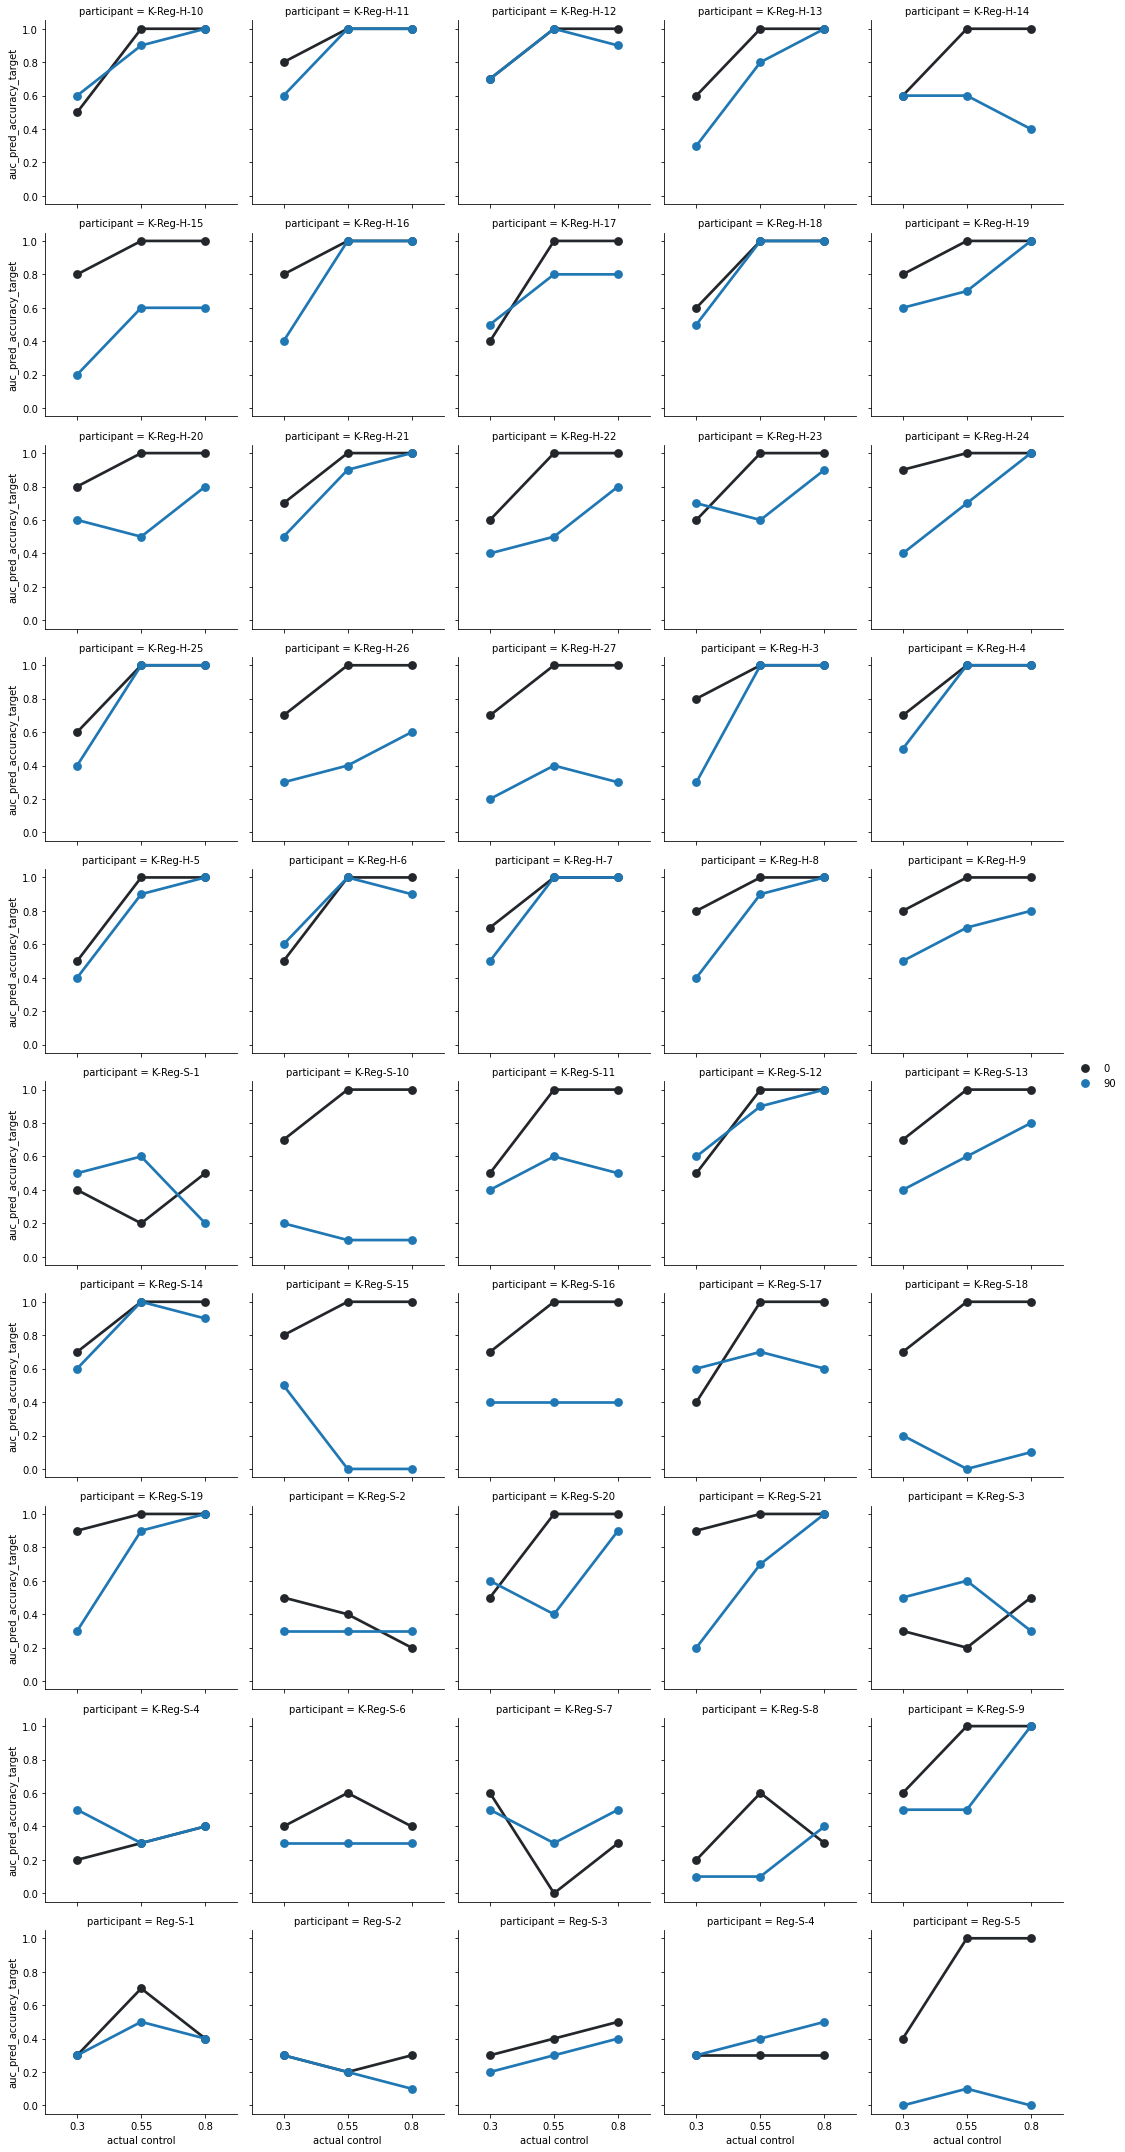

<Figure size 432x288 with 0 Axes>

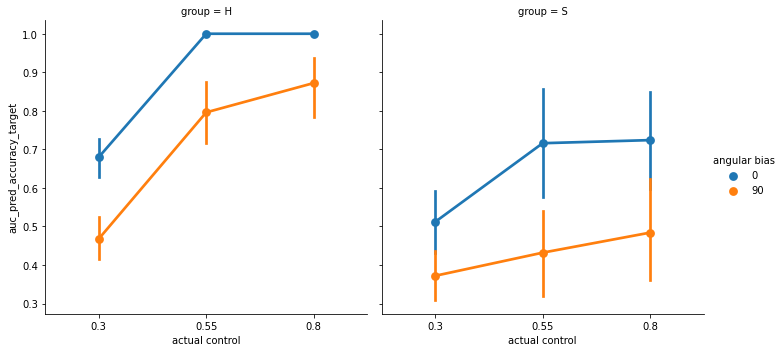

In [31]:
df_ = df.copy()
df_ = df_[['participant', 'actual control', 'angular bias', 'auc_pred_accuracy_target', 'group']]
df_ = df_.groupby(['participant', 'actual control', 'angular bias', 'group']).mean()
df_ = df_.reset_index()

grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='auc_pred_accuracy_target', 
                   hue='angular bias')
grid.add_legend()


plt.figure()
sns.catplot(x='actual control', y='auc_pred_accuracy_target', hue='angular bias', data=df_, col='group', kind='point')


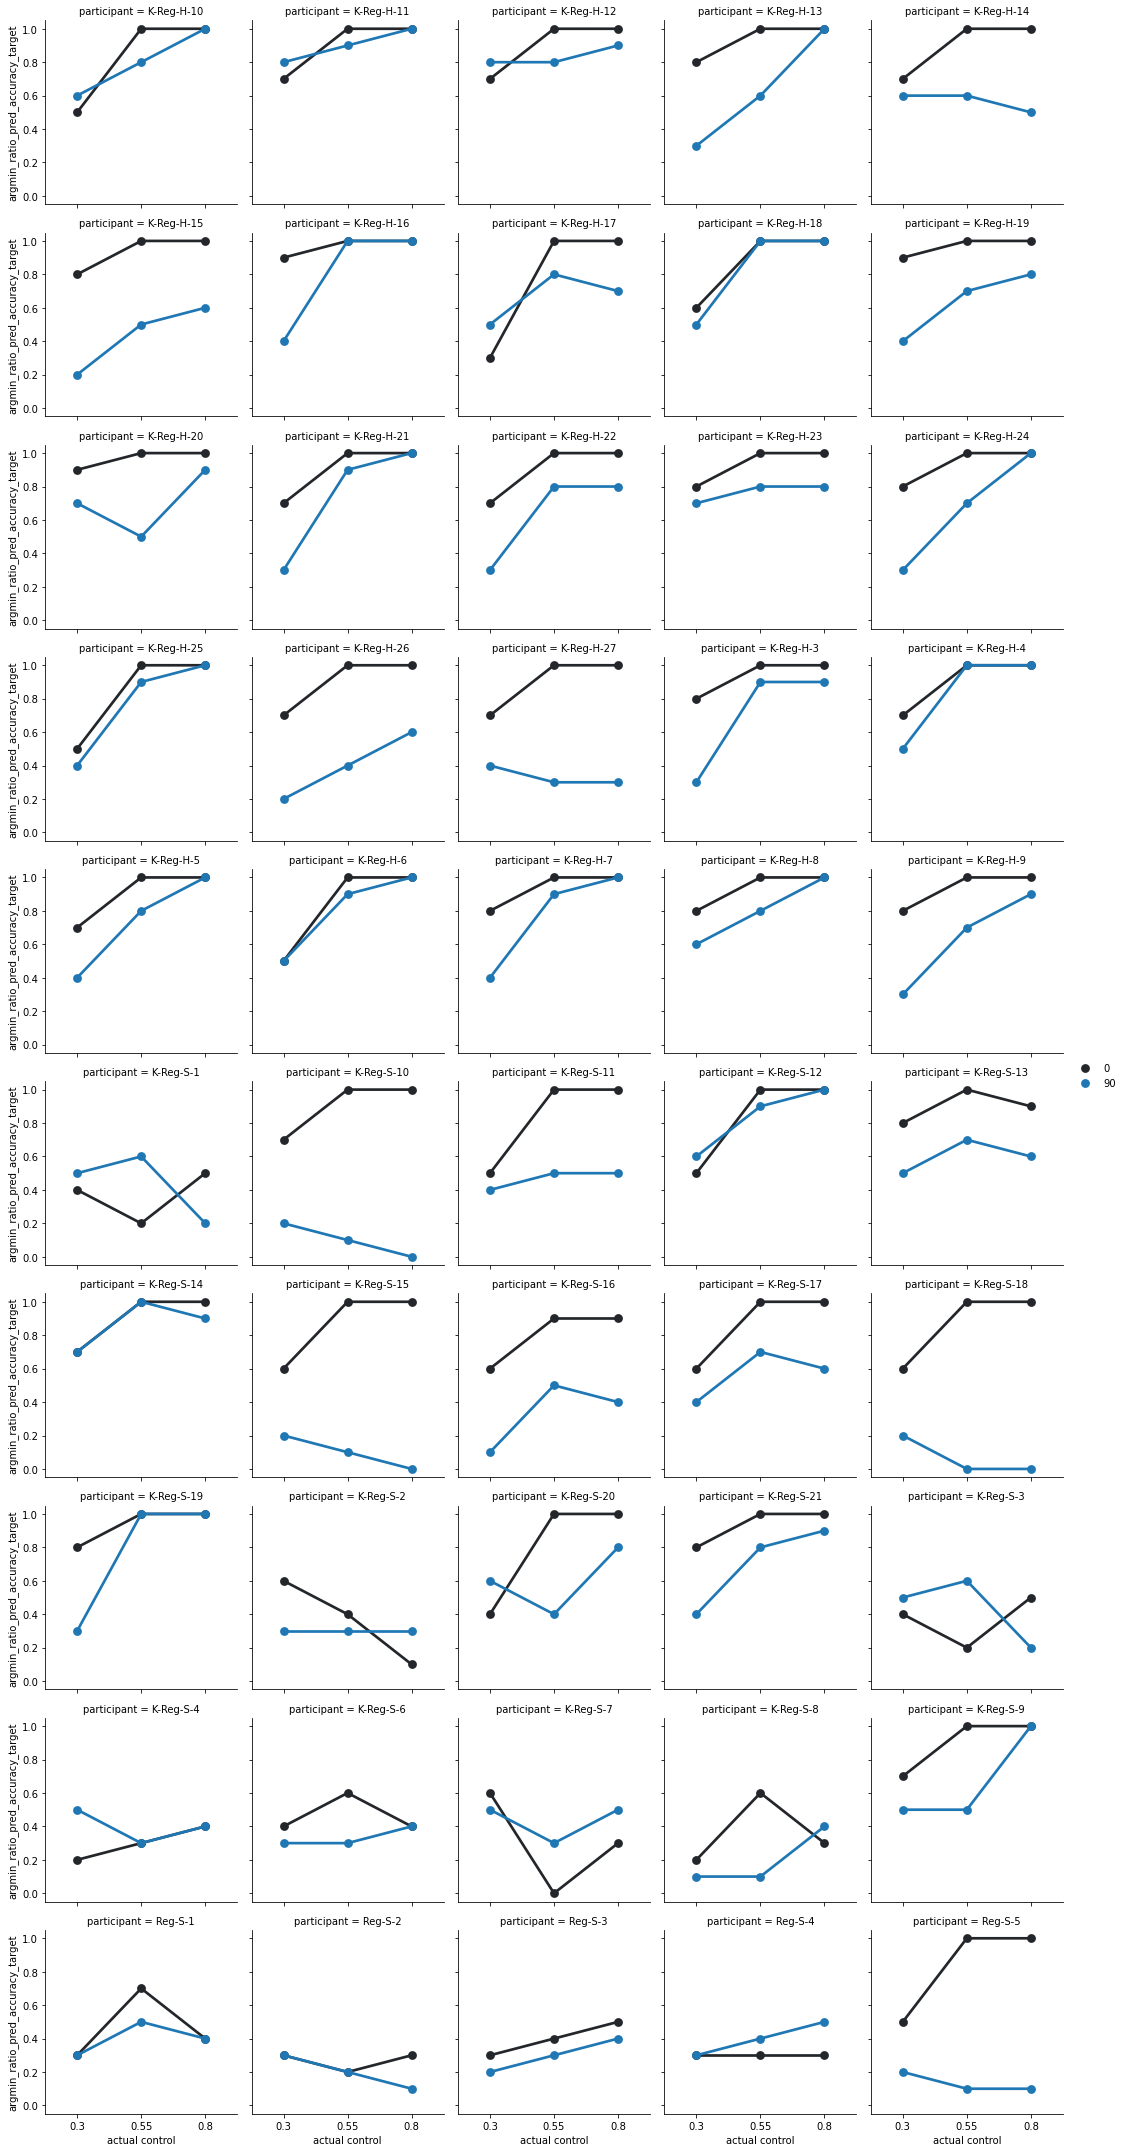

<Figure size 432x288 with 0 Axes>

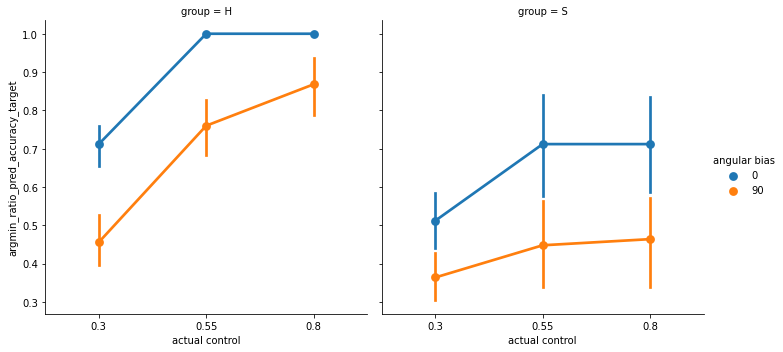

In [29]:
df_ = df.copy()
df_ = df_[['participant', 'actual control', 'angular bias', 'argmin_ratio_pred_accuracy_target', 'group']]
df_ = df_.groupby(['participant', 'actual control', 'angular bias', 'group']).mean()
df_ = df_.reset_index()

grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='argmin_ratio_pred_accuracy_target', 
                   hue='angular bias')
grid.add_legend()

plt.figure()
sns.catplot(x='actual control', y='argmin_ratio_pred_accuracy_target', hue='angular bias', data=df_, col='group', kind='point')


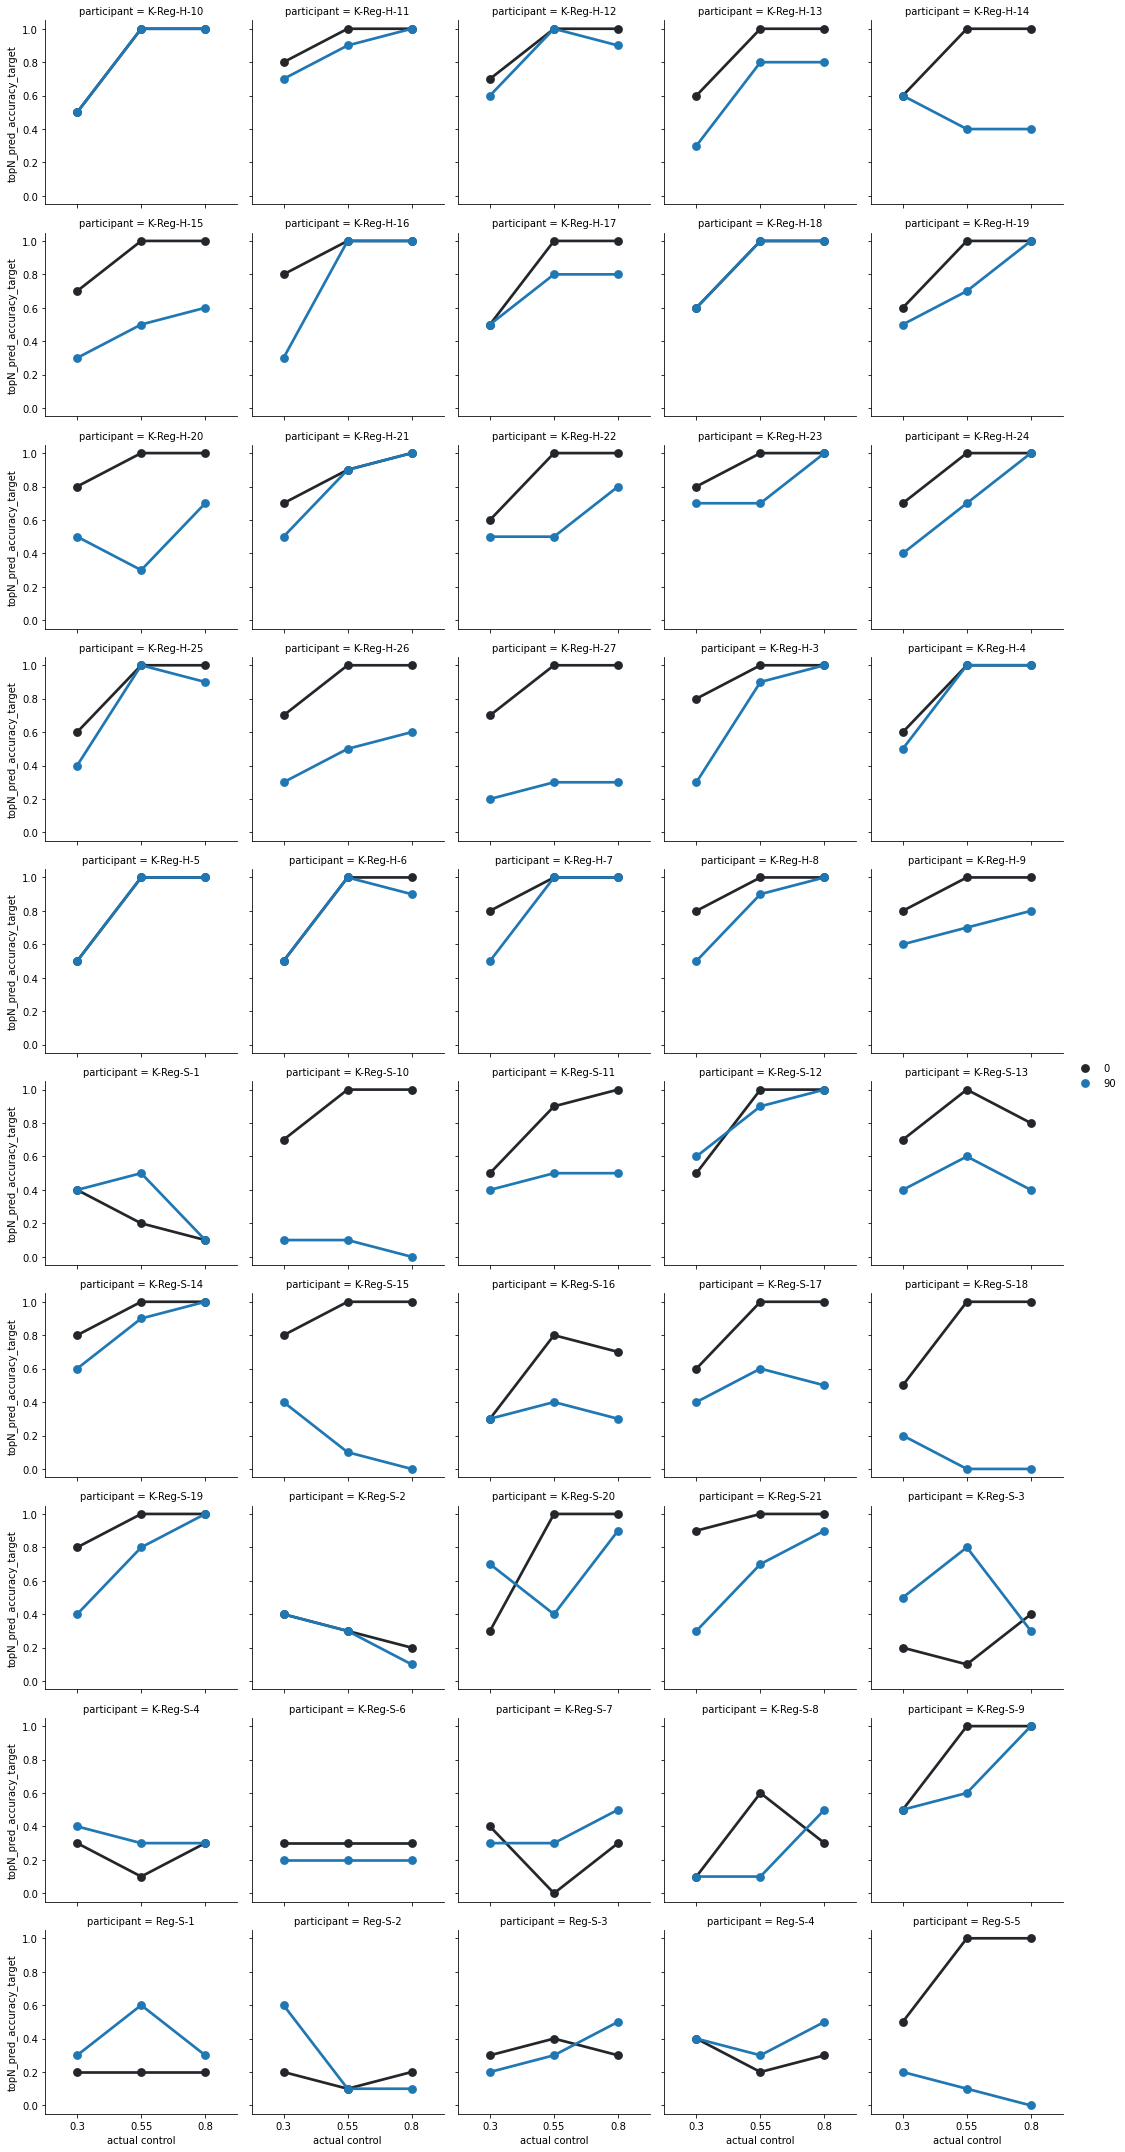

<Figure size 432x288 with 0 Axes>

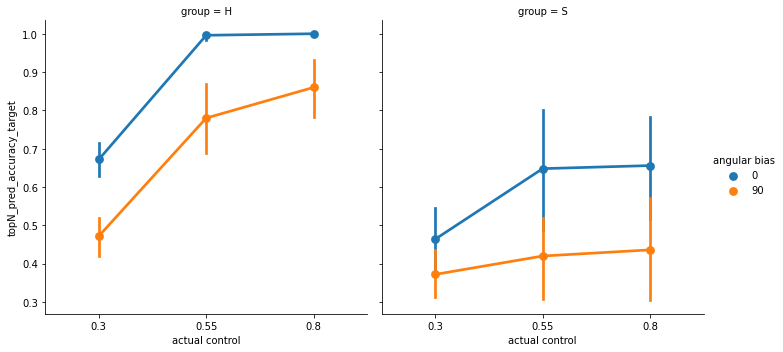

In [30]:
df_ = df.copy()
df_ = df_[['participant', 'actual control', 'angular bias', 'topN_pred_accuracy_target', 'group']]
df_ = df_.groupby(['participant', 'actual control', 'angular bias', 'group']).mean()
df_ = df_.reset_index()

grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='topN_pred_accuracy_target', 
                   hue='angular bias')
grid.add_legend()

plt.figure()
sns.catplot(x='actual control', y='topN_pred_accuracy_target', hue='angular bias', data=df_, col='group', kind='point')


# Predicting choises

In [35]:
df_ = df.copy()
df_ = df_.query('group=="H"')
df_['argmin_ratio_pred_accuracy'].mean()

0.672